<h1> ML Pipeline - Random Forest<h1>

In [1]:
#data handling
import pandas as pd
import numpy as np

#visualisation
import matplotlib.pyplot as plt

#dividing into train/test
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

#model building
from sklearn.ensemble import RandomForestRegressor

#model evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# to persist the model and the scaler
import joblib

# pipeline
from sklearn.pipeline import Pipeline


<h1> Dataset </h1>

In [2]:
#defining feature names
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [3]:
train = pd.read_csv('CMAPSSData/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
test = pd.read_csv('CMAPSSData/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
rul = pd.read_csv('CMAPSSDATA/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])

In [4]:
train.describe() #can drop setting 3 as there is no change
#train = train.drop('setting_3', axis=1)

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [5]:
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [6]:
def add_RUL_column(df):
    
    #get total number of cycles for each unit
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    
    #merge the max cycle back into original frame
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    
    #calculate remaining useful life for each row
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    
    #drop max cycle as it's no longer needed
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged


In [7]:
train = add_RUL_column(train)
#train[sensor_names+['RUL']].head()


In [8]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

<h1> Train Test Split </h1>

In [9]:
drop_labels = index_names+setting_names
X_train=train.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test=train_test_split(
    X_train.drop('RUL', axis=1), #predictor
    X_train['RUL'], #target
    test_size=0.3, #split
    random_state=0) #set seed for reproducibility

In [10]:
X_train.shape, X_test.shape

((14441, 21), (6190, 21))

<h1> Scaler </h1>

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


#Scaling X_train and X_test
X_train =scaler.fit_transform(X_train)
X_test =scaler.fit_transform(X_test)

#Scaling the unseen data (test dataset)
X_valid = test.groupby('unit_number').last().reset_index().drop(columns=drop_labels)
X_valid =scaler.fit_transform(X_valid)

<h1> Random Forest Model </h1>

In [12]:
rf = RandomForestRegressor(random_state = 0)
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=0)

<h1> Predict & Evaluate </h1>

In [13]:
#Evaluation Function

def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_hat)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}, MAE:{}'.format(label, rmse, variance, mae))

In [14]:
#Make prediction for X_train Set

rf_train = rf.predict(X_train)
evaluate(y_train, rf_train, label = 'train')

#Make prediction for X_test Set
rf_test = rf.predict(X_test)
evaluate(y_test, rf_test, label = 'test')


train set RMSE:15.699321839883893, R2:0.9484422683107016, MAE:10.996463541306003
test set RMSE:41.82147909062935, R2:0.6246836192735048, MAE:29.60851211631664


<h1> Saving the Model </h1>

In [15]:
joblib.dump(rf, 'rf_base.joblib') 

['rf_base.joblib']

<h1> Scoring the Data </h1> 
Scoring data helps you understand how well your model performs on unseen data and whether it generalizes well beyond the data it was trained on. This evaluation is crucial for assessing the model's effectiveness and identifying potential issues like overfitting or underfitting.

In [16]:
#Make prediction for FD001 test set - X_valid
rf_valid = rf.predict(X_valid)
evaluate(rul,rf_valid, label = 'valid')

valid set RMSE:36.71433924231785, R2:0.21942994074364364, MAE:27.7984


doesn't seem to be generalising well - on unseen data

Text(0.5, 1.0, 'Evaluation of RUL Predictions using RF')

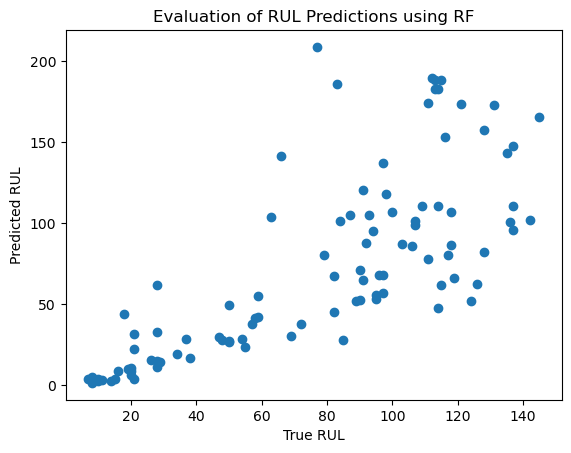

In [17]:
plt.scatter(rul, rf_valid)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Evaluation of RUL Predictions using RF')

In [18]:
def plot_predActual(y_test, y_test_hat):
  
    indices = np.arange(len(y_test_hat))
    wth= 0.7
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL', alpha = 0.5)
    plt.bar([i for i in indices], predicted_values, width=wth, color='r', label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

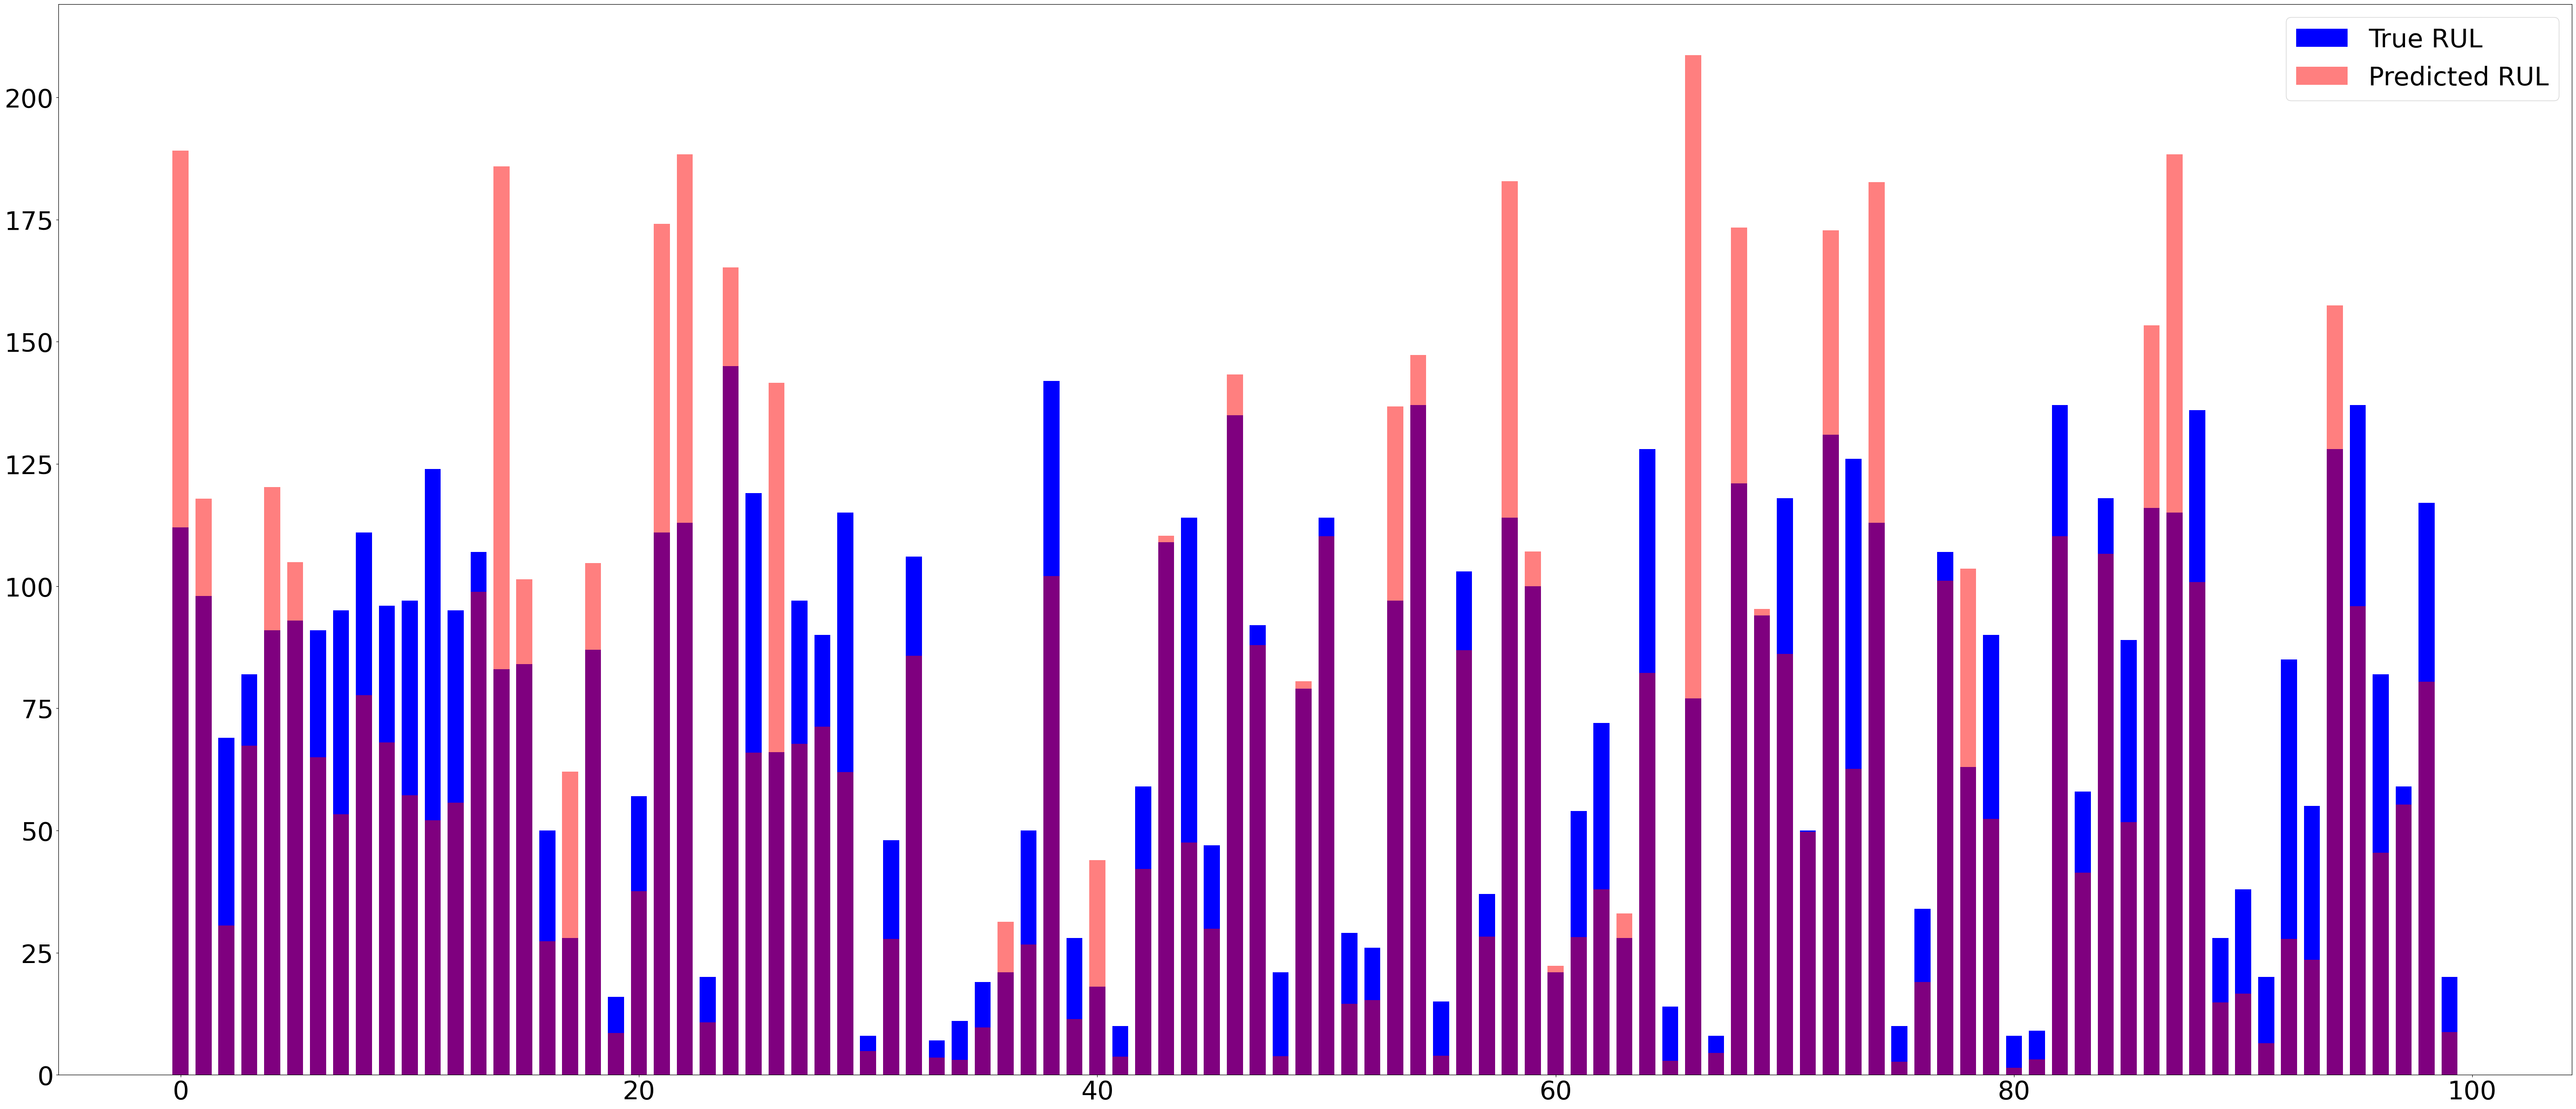

In [19]:
plot_predActual(rul,rf_valid)